In [46]:
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchinfo import summary
from sklearn.metrics import classification_report

In [47]:
SEED = 42
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
device

device(type='cuda')

In [49]:
DATA_DIR = '../data'
RAW_DIR = os.path.join(DATA_DIR, 'raw')
MODELS_SAVE_DIR = '../models'
TRAIN_DIR = os.path.join(RAW_DIR, 'training_set/training_set')
TEST_DIR = os.path.join(RAW_DIR, 'test_set/test_set')

In [50]:
IMAGE_SIZE = 224
IMAGE_CHANNELS = 3
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

#### Loading the dataset and visualizing samples

In [51]:
train_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5] * IMAGE_CHANNELS, [0.5] * IMAGE_CHANNELS)])


test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5] * IMAGE_CHANNELS, [0.5] * IMAGE_CHANNELS)])

In [53]:
train = ImageFolder(TRAIN_DIR, transform=train_transform)
test = ImageFolder(TEST_DIR, transform=test_transform)

In [54]:
val_size = int(0.15 * len(train))
train_size = len(train) - val_size
train, val = random_split(train, [train_size, val_size])

In [55]:
len(train), len(val), len(test)

(6805, 1200, 2023)

In [56]:
classes = train.dataset.classes
class_map = {i: classes[i] for i in range(len(classes))}
class_map

{0: 'cats', 1: 'dogs'}

In [59]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

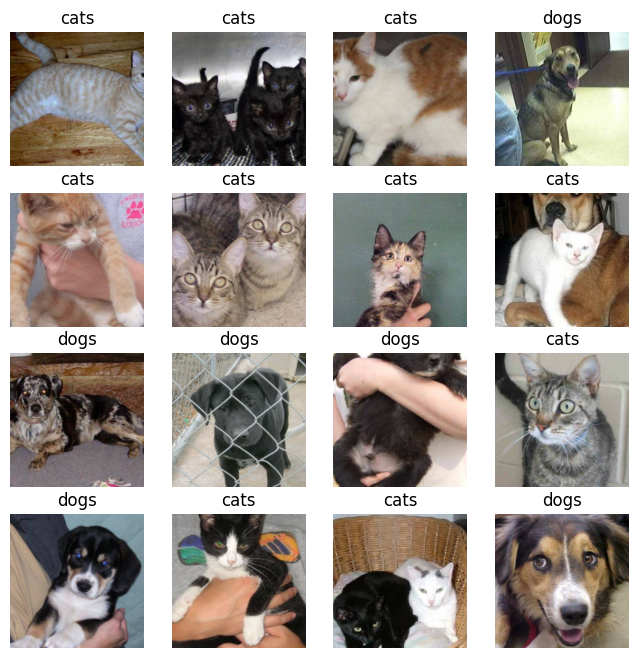

In [58]:
images_sample = next(iter(train_loader))

fig = plt.figure(figsize=(8, 8))
cols, rows = 4, 4

for i in range(cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(images_sample[0][i].permute(1, 2, 0)/2 + 0.5)
    plt.title(class_map[images_sample[1][i].item()])
    plt.axis('off')
plt.show()

#### Building model and blocks

In [60]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.avg_pool(x).view(x.size(0), -1)
        out = self.fc(out).view(x.size(0), x.size(1), 1, 1)
        return out * x
    

class DepthwiseSeparableBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class BottleNeckResBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, stride=1, expansion=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels * expansion, kernel_size=1),
        )
        
        if in_channels != mid_channels * expansion:
            self.shortcut = nn.Conv2d(in_channels, mid_channels * expansion, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class CNN(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(512, 2048), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class SECNN(CNN):
    def __init__(self, in_channels, num_classes, dropout=0.5):
        super().__init__(in_channels, num_classes, dropout)
        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)
        self.se5 = SEBlock(512)

    def forward(self, x):
        x = self.block1(x)
        x = self.se1(x)
        x = self.block2(x)
        x = self.se2(x)
        x = self.block3(x)
        x = self.se3(x)
        x = self.block4(x)
        x = self.se4(x)
        x = self.block5(x)
        x = self.se5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    

class ResBottleneckCNN(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block2 = nn.Sequential(
            BottleNeckResBlock(64, 64),
            BottleNeckResBlock(256, 64),
        )
        self.block3 = nn.Sequential(
            BottleNeckResBlock(256, 128, stride=2),
            BottleNeckResBlock(512, 128),
        )
        self.block4 = nn.Sequential(
            BottleNeckResBlock(512, 256, stride=2),
            BottleNeckResBlock(1024, 256),
        )
        self.block5 = nn.Sequential(
            BottleNeckResBlock(1024, 512, stride=2),
            BottleNeckResBlock(2048, 512),
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, 2048), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class DepthwiseSeparableCNN(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.5):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            DepthwiseSeparableBlock(64, 128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            DepthwiseSeparableBlock(128, 256),
            nn.ReLU(),
            DepthwiseSeparableBlock(256, 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            DepthwiseSeparableBlock(256, 512),
            nn.ReLU(),
            DepthwiseSeparableBlock(512, 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            DepthwiseSeparableBlock(512, 512),
            nn.ReLU(),
            DepthwiseSeparableBlock(512, 512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(512, 2048), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [61]:
def get_acc(predicitons, labels):
    return (predicitons.argmax(dim=1) == labels).float().mean()
    

def train_epoch(model, loader, criterion, optimizer, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    loop = tqdm(loader)
    for img, label in loop:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        preds = model(img)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        acc = get_acc(preds, label).item()
        running_accuracy += acc
        loop.set_description(f'Epoch {epoch + 1}/{num_epochs}')
        loop.set_postfix(loss=loss.item(), accuracy=acc)

    return running_loss / len(loader), running_accuracy / len(loader)


def val_epoch(model, loader, criterion, epoch, num_epochs):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    loop = tqdm(loader)
    with torch.no_grad():
        for img, label in loop:
            img, label = img.to(device), label.to(device)
            preds = model(img)
            loss = criterion(preds, label)
            running_loss += loss.item()
            acc = get_acc(preds, label).item()
            running_accuracy += acc
            loop.set_description(f'Epoch {epoch + 1}/{num_epochs}')
            loop.set_postfix(loss=loss.item(), accuracy=acc)

    return running_loss / len(loader), running_accuracy / len(loader)


def test_model(model, loader):
    model.eval()
    running_accuracy = 0.0
    preds_list = []
    labels_list = []
    loop = tqdm(loader)
    with torch.no_grad():
        for img, label in loop:
            img, label = img.to(device), label.to(device)
            preds = model(img)
            running_accuracy += get_acc(preds, label)
            preds_list.append(preds)
            labels_list.append(label)

    return running_accuracy / len(loader), torch.cat(preds_list), torch.cat(labels_list)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [65]:
standard_cnn = CNN(IMAGE_CHANNELS, len(classes)).to(device)
se_cnn = SECNN(IMAGE_CHANNELS, len(classes)).to(device)
depthwise_cnn = DepthwiseSeparableCNN(IMAGE_CHANNELS, len(classes)).to(device)
resbottleneck_cnn= ResBottleneckCNN(IMAGE_CHANNELS, len(classes)).to(device)

In [66]:
print('--- Standard CNN ---')
print(summary(standard_cnn, input_size=(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)))
print('--- SE CNN ---')
print(summary(se_cnn, input_size=(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)))
print('--- Depthwise CNN ---')
print(summary(depthwise_cnn, input_size=(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)))
print('--- ResBottleneck CNN ---')
print(summary(resbottleneck_cnn, input_size=(1, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)))

--- Standard CNN ---
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56

In [36]:
loss_acc = {}

for model, name in zip([standard_cnn, se_cnn, depthwise_cnn, resbottleneck_cnn], ['standard_cnn', 'se_cnn', 'depthwise_cnn', 'resbottleneck_cnn']):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    loss_acc[name] = (train_losses, train_accuracies, val_losses, val_accuracies)
    with open(f'{MODELS_SAVE_DIR}/{name}_loss_acc.pkl', 'wb') as f:
        pickle.dump(loss_acc, f)
    torch.save(model.state_dict(), f'{MODELS_SAVE_DIR}/{name}.pth')

Epoch 1/5: 100%|██████████| 38/38 [00:25<00:00,  1.52it/s, accuracy=0.812, loss=0.658]


Training Loss: 0.6917, Training Accuracy: 0.5095
Validation Loss: 0.6764, Validation Accuracy: 0.5987


Epoch 2/5: 100%|██████████| 38/38 [00:26<00:00,  1.45it/s, accuracy=0.812, loss=0.605]


Training Loss: 0.6755, Training Accuracy: 0.5609
Validation Loss: 0.6592, Validation Accuracy: 0.6151


Epoch 3/5: 100%|██████████| 38/38 [00:24<00:00,  1.54it/s, accuracy=0.75, loss=0.508] 


Training Loss: 0.6546, Training Accuracy: 0.5986
Validation Loss: 0.6089, Validation Accuracy: 0.6595


Epoch 4/5: 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, accuracy=0.875, loss=0.488]


Training Loss: 0.6131, Training Accuracy: 0.6652
Validation Loss: 0.6019, Validation Accuracy: 0.6587


Epoch 5/5: 100%|██████████| 38/38 [00:25<00:00,  1.49it/s, accuracy=0.75, loss=0.541] 


Training Loss: 0.5898, Training Accuracy: 0.6933
Validation Loss: 0.5975, Validation Accuracy: 0.6645


Epoch 1/5: 100%|██████████| 38/38 [00:24<00:00,  1.54it/s, accuracy=0.312, loss=0.696]


Training Loss: 0.6932, Training Accuracy: 0.5083
Validation Loss: 0.6934, Validation Accuracy: 0.4679


Epoch 2/5: 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, accuracy=0.688, loss=0.585]


Training Loss: 0.6682, Training Accuracy: 0.5884
Validation Loss: 0.6821, Validation Accuracy: 0.5757


Epoch 3/5: 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, accuracy=0.812, loss=0.518]


Training Loss: 0.6432, Training Accuracy: 0.6426
Validation Loss: 0.6345, Validation Accuracy: 0.6620


Epoch 4/5: 100%|██████████| 38/38 [00:24<00:00,  1.53it/s, accuracy=0.812, loss=0.477]


Training Loss: 0.6281, Training Accuracy: 0.6550
Validation Loss: 0.6134, Validation Accuracy: 0.6678


Epoch 5/5: 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, accuracy=0.812, loss=0.443]


Training Loss: 0.6104, Training Accuracy: 0.6669
Validation Loss: 0.6018, Validation Accuracy: 0.6785


Epoch 1/5: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, accuracy=0.312, loss=0.698]


Training Loss: 0.6941, Training Accuracy: 0.4966
Validation Loss: 0.6941, Validation Accuracy: 0.4679


Epoch 2/5: 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, accuracy=0.312, loss=0.703]


Training Loss: 0.6939, Training Accuracy: 0.4893
Validation Loss: 0.6951, Validation Accuracy: 0.4679


Epoch 3/5: 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, accuracy=0.312, loss=0.696]


Training Loss: 0.6937, Training Accuracy: 0.4934
Validation Loss: 0.6936, Validation Accuracy: 0.4679


Epoch 4/5: 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, accuracy=0.312, loss=0.694]


Training Loss: 0.6936, Training Accuracy: 0.4900
Validation Loss: 0.6933, Validation Accuracy: 0.4679


Epoch 5/5: 100%|██████████| 38/38 [00:22<00:00,  1.72it/s, accuracy=0.312, loss=0.716]


Training Loss: 0.6932, Training Accuracy: 0.5073
Validation Loss: 0.6985, Validation Accuracy: 0.4679


Epoch 1/5: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, accuracy=0.688, loss=0.684]


Training Loss: 0.6938, Training Accuracy: 0.5041
Validation Loss: 0.6916, Validation Accuracy: 0.5321


Epoch 2/5: 100%|██████████| 38/38 [00:22<00:00,  1.66it/s, accuracy=0.812, loss=0.534]


Training Loss: 0.6791, Training Accuracy: 0.5542
Validation Loss: 0.6447, Validation Accuracy: 0.6225


Epoch 3/5: 100%|██████████| 38/38 [00:22<00:00,  1.68it/s, accuracy=0.812, loss=0.476]


Training Loss: 0.6534, Training Accuracy: 0.6216
Validation Loss: 0.6272, Validation Accuracy: 0.6439


Epoch 4/5: 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, accuracy=0.875, loss=0.451]


Training Loss: 0.6341, Training Accuracy: 0.6481
Validation Loss: 0.6131, Validation Accuracy: 0.6653


Epoch 5/5: 100%|██████████| 38/38 [00:22<00:00,  1.67it/s, accuracy=0.75, loss=0.481] 

Training Loss: 0.6239, Training Accuracy: 0.6550
Validation Loss: 0.6224, Validation Accuracy: 0.6505


In [55]:
import pandas as pd

for name in loss_acc:
    train_losses, train_accuracies, val_losses, val_accuracies = loss_acc[name]
    df = pd.DataFrame({'train_loss': train_losses, 'train_accuracy': train_accuracies, 'val_loss': val_losses, 'val_accuracy': val_accuracies})
    print(name)
    display(df)

standard_cnn


,train_loss,train_accuracy,val_loss,val_accuracy
0,0.691745,0.509501,0.676442,0.598684
1,0.675455,0.560858,0.659232,0.615132
2,0.654607,0.598557,0.608926,0.659539
3,0.613132,0.665172,0.601925,0.658717
4,0.589836,0.693271,0.597547,0.664474


se_cnn


,train_loss,train_accuracy,val_loss,val_accuracy
0,0.693207,0.508335,0.693386,0.467928
1,0.668206,0.588371,0.682111,0.575658
2,0.643177,0.642585,0.634491,0.662007
3,0.628082,0.655041,0.613358,0.667763
4,0.610422,0.666862,0.601781,0.678454


depthwise_cnn


,train_loss,train_accuracy,val_loss,val_accuracy
0,0.694130,0.496584,0.694123,0.467928
1,0.693926,0.489262,0.695082,0.467928
2,0.693657,0.493433,0.693623,0.467928
3,0.693620,0.489989,0.693336,0.467928
4,0.693197,0.507301,0.698488,0.467928


resbottleneck_cnn


,train_loss,train_accuracy,val_loss,val_accuracy
0,0.693810,0.504066,0.691604,0.532072
1,0.679072,0.554249,0.644740,0.622533
2,0.653383,0.621605,0.627212,0.643914
3,0.634131,0.648090,0.613081,0.665296
4,0.623885,0.654971,0.622374,0.650493


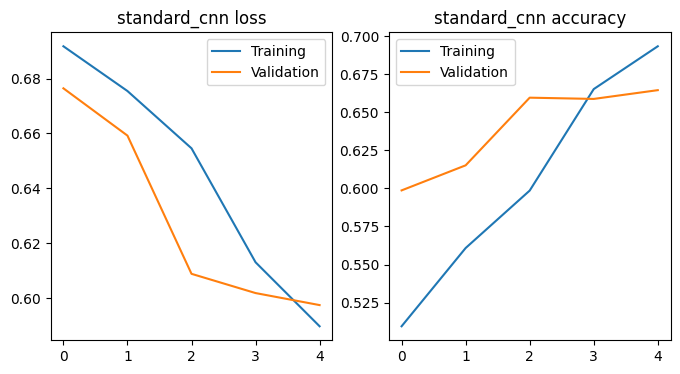

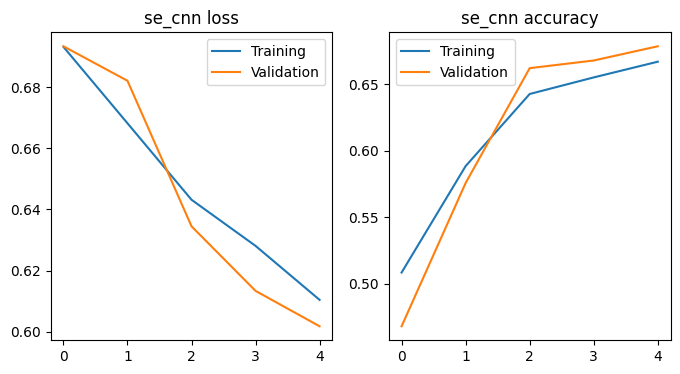

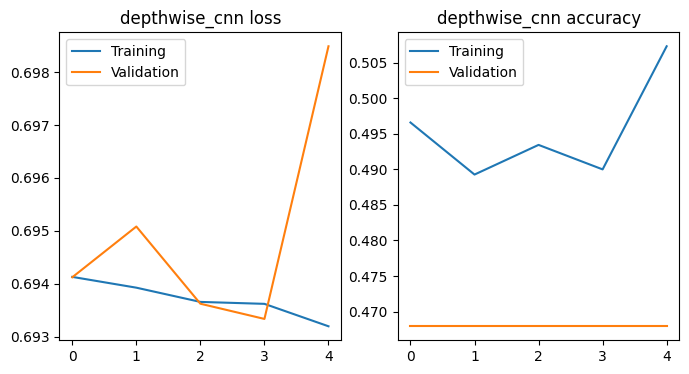

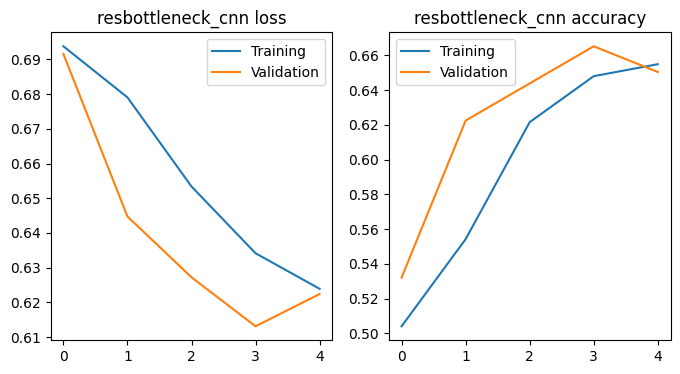

In [42]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, name):
    fig = plt.figure(figsize=(8, 4))
    cols, rows = 2, 1
    for i, (train, val) in enumerate([(train_losses, val_losses), (train_accuracies, val_accuracies)]):
        fig.add_subplot(rows, cols, i+1)
        plt.plot(train, label='Training')
        plt.plot(val, label='Validation')
        plt.legend()

        plt.title(f'{name} loss' if i == 0 else f'{name} accuracy')
    plt.show()

for name in loss_acc:
    train_losses, train_accuracies, val_losses, val_accuracies = loss_acc[name]
    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, name)

In [43]:
test_results = {}
for model, name in zip([standard_cnn, se_cnn, depthwise_cnn, resbottleneck_cnn], ['standard_cnn', 'se_cnn', 'depthwise_cnn', 'resbottleneck_cnn']):
    #model.load_state_dict(torch.load(f'{MODELS_SAVE_DIR}/{name}.pth'))
    accuracy, preds, labels = test_model(model, test_loader)
    test_results[name] = (accuracy, preds, labels)
    print(f'{name} accuracy: {accuracy:.4f}')

100%|██████████| 64/64 [00:19<00:00,  3.29it/s]


standard_cnn accuracy: 0.6770


100%|██████████| 64/64 [00:08<00:00,  7.39it/s]


se_cnn accuracy: 0.6757


100%|██████████| 64/64 [00:07<00:00,  8.94it/s]


depthwise_cnn accuracy: 0.5063


 98%|█████████▊| 63/64 [00:07<00:00,  8.86it/s]c:\Users\Vitaliy\anaconda3\envs\main\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 64/64 [00:07<00:00,  8.74it/s]

resbottleneck_cnn accuracy: 0.6535


In [ ]:
for name in test_results:
    accuracy, preds, labels = test_results[name]
    print(f'{name} accuracy: {accuracy:.4f}')
    print(classification_report(labels.cpu(), preds.argmax(dim=1).cpu(), target_names=classes, zero_division=0))

standard_cnn accuracy: 0.6770
              precision    recall  f1-score   support

        cats       0.76      0.52      0.61      1011
        dogs       0.63      0.83      0.72      1012

    accuracy                           0.67      2023
   macro avg       0.69      0.67      0.67      2023
weighted avg       0.69      0.67      0.67      2023

se_cnn accuracy: 0.6757
              precision    recall  f1-score   support

        cats       0.72      0.57      0.64      1011
        dogs       0.65      0.78      0.70      1012

    accuracy                           0.68      2023
   macro avg       0.68      0.68      0.67      2023
weighted avg       0.68      0.68      0.67      2023

depthwise_cnn accuracy: 0.5063
              precision    recall  f1-score   support

        cats       0.00      0.00      0.00      1011
        dogs       0.50      1.00      0.67      1012

    accuracy                           0.50      2023
   macro avg       0.25      0.50      0.33